# 1_Train

   El modelo de ML utiliza para entrenar un dataset compuesto por imágenes y máscaras para el entrenamiento. Estas ultimas son imagenes binarias que delimitan el objeto de interés, 1 donde esta y 0 donde no. 

In [ ]:
#!pip install pysatproc unetseg

In [1]:
from unetseg.train import TrainConfig, train
from unetseg.evaluate import plot_data_generator
import os


2022-07-12 19:20:10.756591: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
#General
BUCKET_TRAIN = "gs://dym-workshops-public/session2//informal-settlements-sentinel2-RGBNIR/imagenes/"
BUCKET_DATA  = "gs://dym-workshops-public/session2//informal-settlements-sentinel2-RGBNIR/data"

BASE_PATH         = "./../"
PATH_TRAIN_IMAGES = f'/images_sentinel2_RGBNIR/'

GT_FILE        = "informal_settlements_all.gpkg"
AOI_TRAIN_FILE = "informal_settlements_epsg4326_claseA_buff2000_dissolve.gpkg"


STEP_PER_EPOCH = 650

SIZE      = 160 
STEP_SIZE = 160

INFO = "v0"
MODEL_NAME = f'UNet_160x160_sentinel2_4D_classA_{INFO}.h5'

BUCKET_MODEL = f"gs://dym-workshops-public/session2//informal-settlements-sentinel2-RGBNIR/data/weights/"


   
## Generacion del data set de entrenamiento

   En esta etapa generamos el dataset de entrenamiento mediante el uso de **GDAL** y **Satproc**. Primero descargamos las imagenes satelitales y utilizamos GDAL para quedarnos con la combinacion de bandas deseada. Luego Utilizamos satproc para generar el dataset con todas las caracteristicas necesarias para el modelo: tamaño , cantidad de imagenes, rango de valores, etc.

Descargamos las imágenes del bucket

In [4]:
folder = BASE_PATH + PATH_TRAIN_IMAGES

In [76]:
#download images
!mkdir -p $folder
!gsutil -m cp -r $BUCKET_TRAIN   $folder 
#dounload vector f
!gsutil -m cp -r $BUCKET_DATA   $BASE_PATH

Podemos verificar que los archivos fueron correctamente descargados

In [15]:
!ls $folder

imagenes


### Satproc

Con la herramienta **satproc_extract_chips** se generan, a partir de las imágenes descargadas del bucket, imágenes (chips) generalmente mas pequeñas y máscaras (utilizando las anotaciones de verdad de campo).

**OBS** : tanto las imagenes como el archivo vectorial deben tener la misma georeferencia, por ejemplo 4326

In [5]:
path_to_files   = f'{folder}/*/*/*tif' #carpeta a las imagenes
output_folder   = f'{BASE_PATH}/dataset/data_train/{str(SIZE)}_{str(STEP_SIZE)}/' #carpeta de destino del dataset
vector_file     = f'{BASE_PATH}/data/shp/gt/{GT_FILE}' # archivo vectorial de verdad de campo
vector_file_aoi = f'{BASE_PATH}/data/shp/{AOI_TRAIN_FILE}' #archivo vectorial con las zonas de interes

Ejecutamos satproc

In [91]:
#!satproc_extract_chips --help

In [104]:
!satproc_extract_chips \
                $path_to_files \
                -o  $output_folder \
                --size $SIZE \
                --step-size $STEP_SIZE \
                --aoi $vector_file_aoi \
                --labels $vector_file \
                --label-property 'class' \
                --skip-low-contrast \
                --classes 'A' \
                --rescale \
                --rescale-mode s2_rgb_extra --lower-cut 1 --upper-cut 100

arg_2016_1.tif windows:   0%|                            | 0/16 [00:00<?, ?it/s]/opt/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/rasterio/features.py:318: ShapeSkipWarning: Invalid or empty shape {'type': 'Polygon', 'coordinates': ()} at index 3960 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)
/opt/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/rasterio/features.py:318: ShapeSkipWarning: Invalid or empty shape {'type': 'Polygon', 'coordinates': ()} at index 3961 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)
/opt/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/rasterio/features.py:318: ShapeSkipWarning: Invalid or empty shape {'type': 'Polygon', 'coordinates': ()} at index 3962 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.fo

/opt/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/rasterio/features.py:318: ShapeSkipWarning: Invalid or empty shape {'type': 'Polygon', 'coordinates': ()} at index 6239 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)
/opt/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/rasterio/features.py:318: ShapeSkipWarning: Invalid or empty shape {'type': 'Polygon', 'coordinates': ()} at index 6240 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)
/opt/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/rasterio/features.py:318: ShapeSkipWarning: Invalid or empty shape {'type': 'Polygon', 'coordinates': ()} at index 6246 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)
/opt/miniconda3/envs/tf-gpu/lib/python3.8/s


arg_2016_106.tif windows:  90%|###############3 | 18/20 [00:07<00:00,  2.53it/s]


arg_2016_109.tif windows:  65%|#########7     | 158/244 [01:02<00:34,  2.50it/s]


arg_2016_116.tif windows:  91%|###############4 | 20/22 [00:07<00:00,  2.58it/s]


arg_2016_123.tif windows:  85%|#############6  | 87/102 [00:34<00:05,  2.54it/s]


Rasters:   9%|##9                              | 32/361 [05:19<53:36,  9.78s/it]


arg_2016_136.tif windows:  42%|#######2         | 17/40 [00:06<00:08,  2.56it/s]


arg_2016_145.tif windows:  22%|####2              | 2/9 [00:00<00:02,  2.58it/s]


Rasters:  17%|#####6                           | 62/361 [08:45<26:26,  5.31s/it]


arg_2016_166.tif windows:  15%|##6               | 3/20 [00:01<00:06,  2.47it/s]


arg_2016_177.tif windows:  25%|####5             | 5/20 [00:01<00:05,  2.50it/s]


arg_2016_185.tif windows:  84%|##############3  | 16/19 [00:06<00:01,  2.62it/s]


arg_2016_193.tif windows:   6%|#1                | 1/16 [00:00<00:06,  2.46it/s]


arg_2016_197.tif windows:  52%|#######8       | 126/241 [00:49<00:45,  2.53it/s]


arg_2016_200.tif windows:  74%|############5    | 14/19 [00:05<00:01,  2.54it/s]


arg_2016_203.tif windows:  33%|######3            | 3/9 [00:01<00:02,  2.44it/s]


arg_2016_213.tif windows:  33%|######            | 4/12 [00:01<00:03,  2.52it/s]


arg_2016_224.tif windows:  39%|######6          | 22/56 [00:08<00:13,  2.50it/s]


arg_2016_230.tif windows:  84%|##############2  | 73/87 [00:28<00:05,  2.54it/s]


arg_2016_239.tif windows:  36%|######           | 10/28 [00:03<00:07,  2.51it/s]


arg_2016_24.tif windows:  74%|###########7    | 174/236 [01:08<00:24,  2.52it/s]


arg_2016_244.tif windows:   4%|7                 | 1/23 [00:00<00:08,  2.56it/s]


arg_2016_249.tif windows:   7%|9             | 106/1545 [00:42<09:51,  2.43it/s]


arg_2016_249.tif windows:  19%|##7           | 300/1545 [02:00<08:17,  2.50it/s]


arg_2016_249.tif windows:  32%|####4         | 494/1545 [03:17<06:56,  2.53it/s]


arg_2016_249.tif windows:  45%|######2       | 688/1545 [04:35<05:45,  2.48it/s]


arg_2016_249.tif windows:  57%|#######9      | 882/1545 [05:54<04:26,  2.48it/s]


arg_2016_249.tif windows:  70%|#########    | 1076/1545 [07:12<03:02,  2.57it/s]


arg_2016_249.tif windows:  82%|##########6  | 1270/1545 [08:31<01:51,  2.46it/s]


arg_2016_249.tif windows:  95%|############3| 1464/1545 [09:50<00:33,  2.43it/s]


arg_2016_253.tif windows:   8%|#5                | 1/12 [00:00<00:04,  2.36it/s]


arg_2016_26.tif windows:   1%|1                 | 2/189 [00:00<01:18,  2.38it/s]


arg_2016_260.tif windows:  20%|###6              | 5/25 [00:02<00:08,  2.44it/s]


arg_2016_269.tif windows:  17%|###               | 2/12 [00:00<00:04,  2.35it/s]


arg_2016_271.tif windows:  61%|#########2     | 150/244 [00:59<00:37,  2.51it/s]


arg_2016_276.tif windows:  58%|##########5       | 7/12 [00:02<00:01,  2.53it/s]


arg_2016_286.tif windows:  35%|#####9           | 24/69 [00:09<00:18,  2.47it/s]


arg_2016_292.tif windows:  47%|########         | 17/36 [00:06<00:07,  2.47it/s]


arg_2016_298.tif windows:  30%|####5          | 102/335 [00:41<01:33,  2.50it/s]


arg_2016_298.tif windows:  88%|#############2 | 296/335 [01:59<00:15,  2.48it/s]


arg_2016_302.tif windows:  84%|##############2  | 21/25 [00:08<00:01,  2.54it/s]


arg_2016_307.tif windows:  91%|###############5 | 63/69 [00:25<00:02,  2.55it/s]


arg_2016_313.tif windows:  90%|##############3 | 97/108 [00:39<00:04,  2.50it/s]


arg_2016_322.tif windows:  52%|########8        | 27/52 [00:10<00:09,  2.56it/s]


arg_2016_331.tif windows:  89%|###############1 | 32/36 [00:12<00:01,  2.46it/s]


arg_2016_335.tif windows:  47%|#######9         | 15/32 [00:05<00:06,  2.55it/s]


arg_2016_342.tif windows:   0%|                          | 0/42 [00:00<?, ?it/s]


arg_2016_349.tif windows:  43%|#######2         | 26/61 [00:10<00:14,  2.46it/s]


arg_2016_36.tif windows:  19%|###6               | 6/31 [00:02<00:09,  2.56it/s]


arg_2016_40.tif windows:   0%|                            | 0/9 [00:00<?, ?it/s]


arg_2016_48.tif windows:  13%|##4                | 4/31 [00:01<00:10,  2.48it/s]


arg_2016_54.tif windows:  75%|#############5    | 18/24 [00:07<00:02,  2.48it/s]


arg_2016_64.tif windows:  73%|#############     | 16/22 [00:06<00:02,  2.51it/s]


arg_2016_71.tif windows:  32%|#####7            | 13/41 [00:05<00:11,  2.45it/s]


arg_2016_77.tif windows:  15%|##8                | 3/20 [00:01<00:06,  2.45it/s]


arg_2016_83.tif windows:  26%|#####              | 5/19 [00:02<00:05,  2.41it/s]


arg_2016_9.tif windows:  11%|##3                  | 1/9 [00:00<00:03,  2.46it/s]


arg_2016_95.tif windows:  36%|######           | 73/205 [00:29<00:51,  2.56it/s]


arg_2016_98.tif windows:  26%|####4            | 29/112 [00:11<00:32,  2.52it/s]


bra_2016_1.tif windows:  14%|##5               | 84/603 [00:33<03:25,  2.53it/s]


bra_2016_1.tif windows:  46%|#######8         | 278/603 [01:50<02:10,  2.50it/s]


bra_2016_1.tif windows:  78%|#############3   | 472/603 [03:07<00:51,  2.53it/s]


col_2015_1.tif windows:  34%|######1           | 47/138 [00:18<00:35,  2.57it/s]


hon_2018_1.tif windows:   5%|9                  | 6/118 [00:02<00:45,  2.45it/s]


par_2016_1.tif windows:  25%|####5             | 80/317 [00:31<01:30,  2.62it/s]


par_2016_1.tif windows:  86%|##############6  | 274/317 [01:48<00:17,  2.42it/s]


Rasters: 100%|##############################| 361/361 [1:18:48<00:00, 13.10s/it]


###### Los argumentos:

* **path_to_files** es la ruta a las imágenes 

* **o** es la ruta de destino 

Recomendamos que dicha ruta sea descriptiva, por ejemplo “data_train/120_40/ ” describe : Data_train → datos usados para entrenar; 120_40 → <tamaño de la imagen >_ <tamaño del step-size> 

* **size** tamaño de las imágenes resultantes o chips (las imágenes son cuadradas) 
* **step-size** paso del proceso. Debe ser menor o igual a *size*. Si *step-size* es igual que el *size* entonces no hay overlap en las imágenes resultantes. 

En ocaciones es útil para el entrenamiento generar los chips con un overlap de este modo tenemos más datos para entrenar. 


* **label-property** nombre del campo donde se define cada categoría (solo se usa para el entrenamiento) 

* **classes** nombres de las clases (como aparecen en el geojson), separados por espacios

* **aoi** ruta al archivo vectorial donde están definidas las anotaciones. Al definir una region de interés solo se procesan las imágenes que interceptan esas anotaciones.

* **rescale** lleva los valores de las bandas a 0-255 

Este comando va a generar dos carpetas en la ruta de destino : “images” y “extent”. Los archivos de la primera van a ser de tipo Tiff de 3 bandas (rgb) y los de la segunda van a ser, también, de tipo Tiff pero de N bandas donde N representa el número de clases, en este caso sólo una. Y donde cada una de las bandas es una máscara binaria


## Entrenamiento

Generamos el entrenamiento del modelo utilizando los datasets creados en el paso previo. El modelo es una red neuronal CNN basado en la arquitectura U-Net. Este considera las imágenes y las máscaras binarias como inputs y genera una imagen con la probabilidad de encontrar al objeto de interés.

En esta etapa debemos definir la configuración del modelo de ML.

In [6]:

config = TrainConfig(width   = 160,  #  tamaño de la imagen procesada por la UNet (debe ser multiplos de 16 , por ej 160, 320,etc; y no menor a 80)
                     height  = 160,
                     n_channels   = 4,  #  número de canales de la imagen, rgb -> 3
                     n_classes    = 1, # número de clases a clasificar
                     apply_image_augmentation = True, #  si es True , amplia el dataset generando imagenes nuevas a partir de pequeñas variaciones de las ya existentes (rotación,)
                     seed       = 42,
                     epochs     = 20, # Cantidad de veces que el dataset entero puede pasar por el proceso de entrenamiento
                     batch_size = 16, #cantidad de datos que se procesan por vez, puede ser limitado por la memoria de gpu disponible (debe ser multiplo de 16)
                     steps_per_epoch  = STEP_PER_EPOCH, #  típicamente debe ser igual al numero de imágenes / el batch_size, si es mayor incrementara el número de imágenes generadas con image augmentation
                     early_stopping_patience  = 5, # a medida que entrena se guardan los resultados del entrenamiento despues de cada epoch, si el error no varió luego de ¿¿10 ?? iteraciones , se corta el proceso porque se entiende que el error ya disminuyó significativamente 
                     validation_split   = 0.1, # se divide la muestra en training (80% de los datos) y validation (20% de los datos) para calcular el error durante el proceso de entrenamiento
                     test_split         = 0.1, # Cantidad de imágenes del dataset
                     images_path        = output_folder,#ruta a las imágenes generadas con Satproc
                     model_path         = os.path.join(BASE_PATH,'data/weights/', MODEL_NAME),#  ruta del modelo entrenado
                     model_architecture = 'unet',
                     evaluate           = True  ,
                     class_weights      = [1]) 

*Obs*: Es util usar un nombre para el archivo de pesos que de información sobre los parametros de entrenamiento. por ejemplo: < modelo >_< proyecto >_< dim_de_las_imagenes >_< size >_< step_size >_< step_per_epoch >.h5 o similares

Podemos visualizar alguna de las imágenes y máscaras del dataset de entrenamiento. A la izquierda se muestra la imágen y a la derecha la máscara 

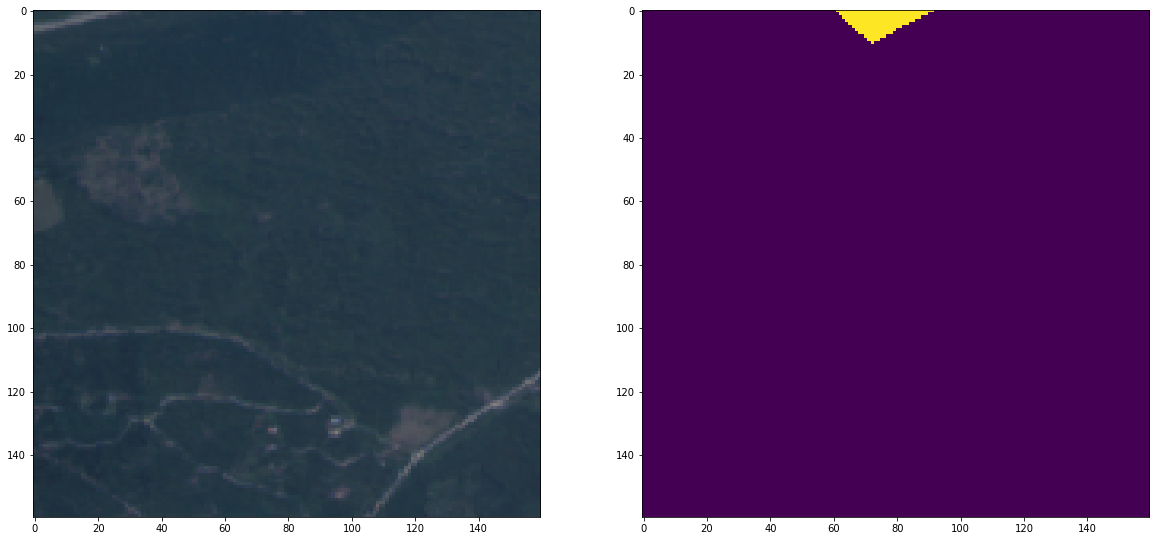

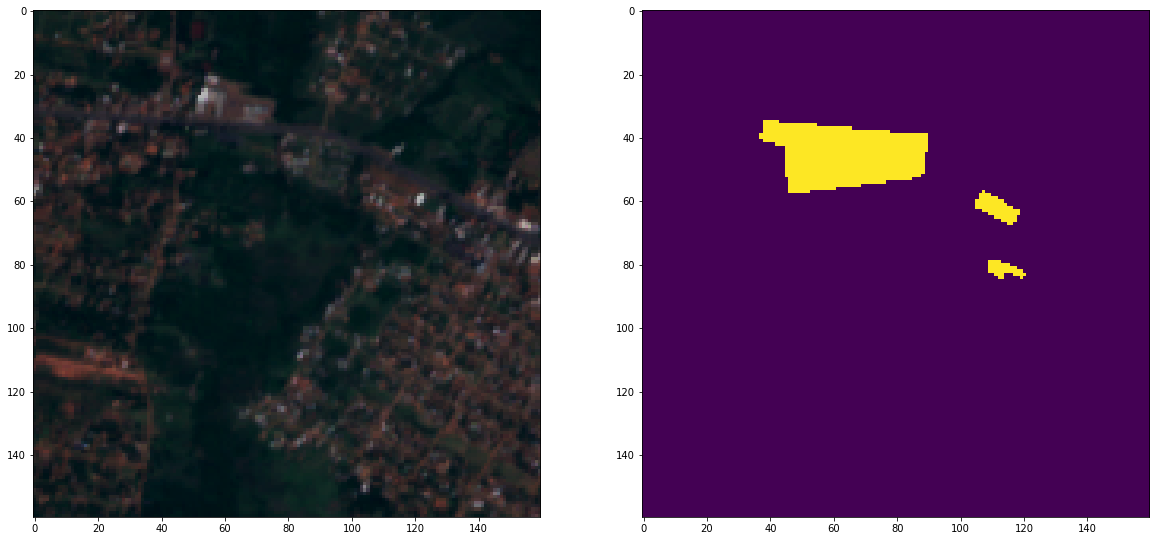

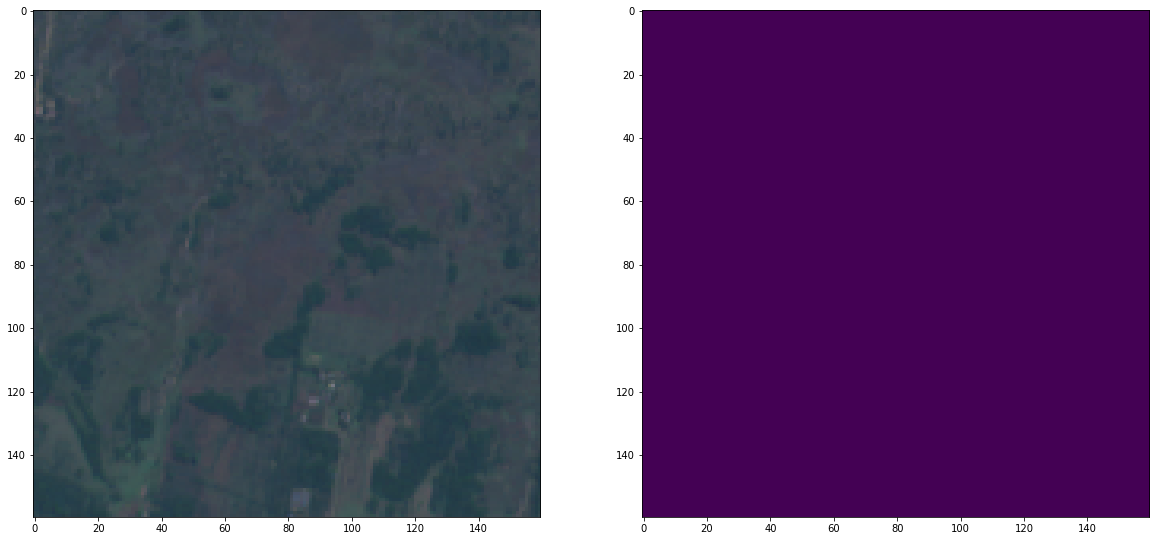

In [8]:
plot_data_generator(num_samples=3, fig_size=(20, 20), train_config=config)

Corremos el entrenamiento.

In [10]:
res_config = train(config)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 4) 0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 160, 160, 32) 1184        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 160, 160, 32) 9248        conv2d_23[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 80, 80, 32)   0           conv2d_24[0][0]                  
____________________________________________________________________________________________

2022-07-12 16:12:18.386500: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-07-12 16:12:18.386529: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-07-12 16:12:18.386606: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-07-12 16:12:18.386622: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


Epoch 1/20
  2/650 [..............................] - ETA: 2:34 - loss: 3.0376 - mean_io_u_1: 0.4937 

2022-07-12 16:12:21.090593: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-07-12 16:12:21.090630: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-07-12 16:12:21.090692: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-07-12 16:12:21.464818: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2022-07-12 16:12:21.471637: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-07-12 16:12:21.474365: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-07-12 16:12:21.477052: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./../logs/UNet_160x160_sentinel2_4D_classA_v0_Date

650/650 [==============================] - 200s 305ms/step - loss: 0.1833 - mean_io_u_1: 0.4906 - val_loss: 0.0899 - val_mean_io_u_1: 0.4913

Epoch 00001: val_loss improved from inf to 0.08994, saving model to ./../data/weights/UNet_160x160_sentinel2_4D_classA_v0.h5
Epoch 2/20
650/650 [==============================] - 196s 302ms/step - loss: 0.0830 - mean_io_u_1: 0.4911 - val_loss: 0.0974 - val_mean_io_u_1: 0.4913

Epoch 00002: val_loss did not improve from 0.08994
Epoch 3/20
650/650 [==============================] - 196s 301ms/step - loss: 0.0808 - mean_io_u_1: 0.4910 - val_loss: 0.0811 - val_mean_io_u_1: 0.4918

Epoch 00003: val_loss improved from 0.08994 to 0.08113, saving model to ./../data/weights/UNet_160x160_sentinel2_4D_classA_v0.h5
Epoch 4/20
650/650 [==============================] - 197s 303ms/step - loss: 0.0821 - mean_io_u_1: 0.4907 - val_loss: 0.0728 - val_mean_io_u_1: 0.4918

Epoch 00004: val_loss improved from 0.08113 to 0.07284, saving model to ./../data/weights/UNet

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
#%tensorboard --logdir ../logs

Graficamos las métricas generadas.

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,4))

plt.subplot(121)
plt.plot(res_config.history['loss'])
plt.plot(res_config.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(122)
plt.plot(res_config.history['mean_io_u_2'])
plt.plot(res_config.history['val_mean_io_u_2'])
plt.title('mean_iou')
plt.ylabel('val_mean_iou')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')


plt.show()


In [ ]:
!gsutil -m cp -r $config.model_path $BUCKET_MODEL